In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")


The most recent date in the dataset is: 2017-08-23


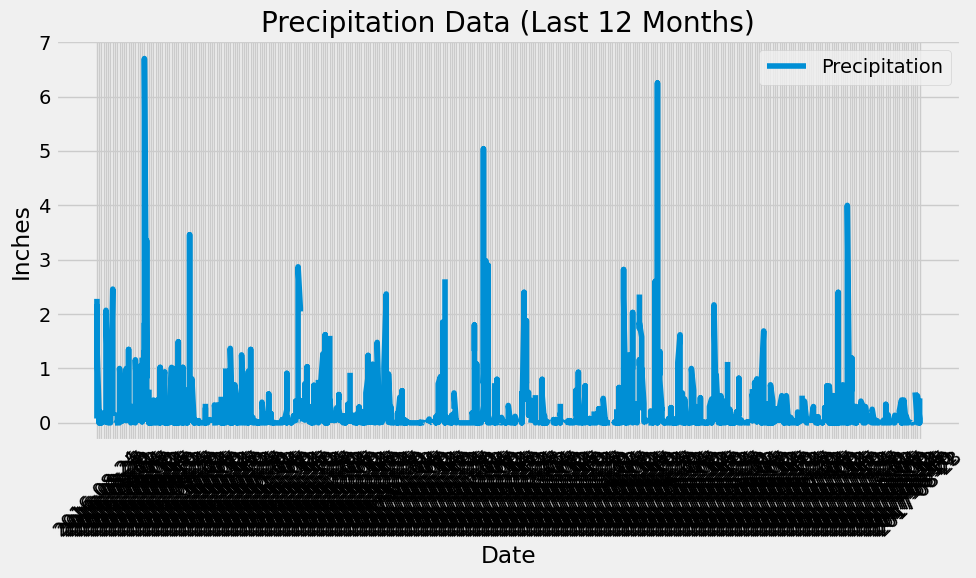

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in the dataset
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= one_year_ago)\
    .order_by(measurement.date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Data (Last 12 Months)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
summary_statistics

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()

print(f"The total number of stations in the dataset is: {total_stations}")

The total number of stations in the dataset is: 9


In [13]:
# Design a query to find the most active stations
most_active_stations = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc())\
    .all()

# List the stations and their counts in descending order.
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Extract the most active station ID from the previous query
most_active_station_id = most_active_stations[0][0]

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
    .filter(measurement.station == most_active_station_id)\
    .all()

# Extract the results and format them into a list of tuples
result_list = [(lowest_temp, highest_temp, avg_temp) for lowest_temp, highest_temp, avg_temp in temperature_stats]
result_list

[(54.0, 85.0, 71.66378066378067)]

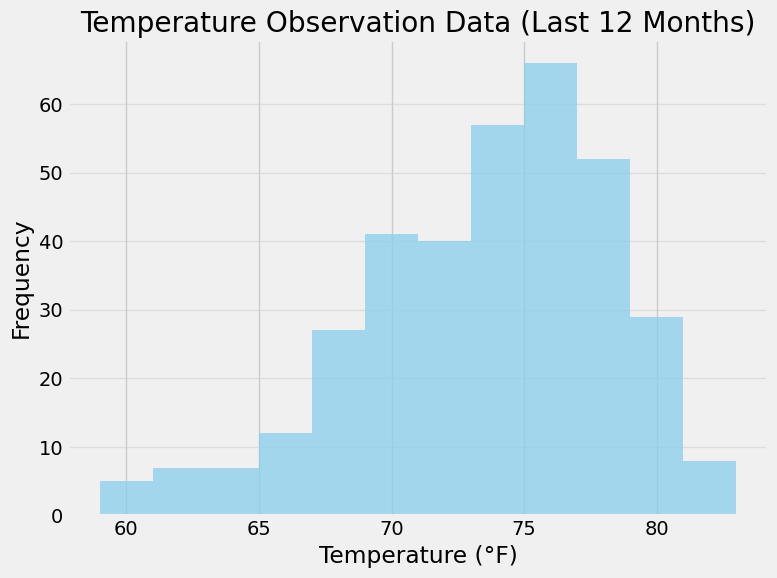

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(measurement.tobs)\
    .filter(measurement.station == most_active_station_id)\
    .filter(measurement.date >= one_year_ago)\
    .all()

# Convert the query results to a list of temperatures
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, color='skyblue', alpha=0.75)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data (Last 12 Months)')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()